In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/DLWeek1/income.csv'
data = pd.read_csv(file_path)

data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [10]:
# Preprocess the data
data_encoded = data.copy()

# Convert categorical columns to numerical using LabelEncoder
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
for col in categorical_columns:
    data_encoded[col] = LabelEncoder().fit_transform(data_encoded[col])

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')

# Drop the target variable (income) from the features for imputation
X_encoded = data_encoded.drop(columns=['income'])

# Apply imputer to the features (X_encoded)
X_imputed = imputer.fit_transform(X_encoded)

# Convert the imputed data back into a DataFrame
data_imputed = pd.DataFrame(X_imputed, columns=X_encoded.columns)

# Re-add the target variable (income) to the DataFrame
data_imputed['income'] = data_encoded['income']

# Standardize the numerical features
numerical_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
scaler = StandardScaler()
data_imputed[numerical_columns] = scaler.fit_transform(data_imputed[numerical_columns])

# Clean the 'income' column by stripping out any extra spaces or punctuation (like periods)
data_imputed['income'] = data_imputed['income'].astype(str)  # Ensure it's a string type
data_imputed['income'] = data_imputed['income'].str.replace('.', '', regex=False)  # Remove periods (.)

# Manually convert 'income' column to binary: 0 for <=50K and 1 for >50K
data_imputed['income'] = data_imputed['income'].apply(lambda x: 1 if x == '>50K' else (0 if x == '<=50K' else x))

# Verify the conversion (check unique values in 'income')
print("Unique values in 'income' column after conversion:", data_imputed['income'].unique())

# Features and target
X = data_imputed.drop(columns=['income'])
y = data_imputed['income']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert target variables to PyTorch tensors (ensure correct dtype)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Convert features to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Check the shape and values of the target tensors
print(f"y_train_tensor shape: {y_train_tensor.shape}, values: {y_train_tensor[:10]}")
print(f"y_test_tensor shape: {y_test_tensor.shape}, values: {y_test_tensor[:10]}")

# Check the first few rows of the 'income' column to confirm conversion
print(data_imputed[['income']].head(20))

Unique values in 'income' column after conversion: [0 1]
y_train_tensor shape: torch.Size([39073, 1]), values: tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.]])
y_test_tensor shape: torch.Size([9769, 1]), values: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
    income
0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        1
8        1
9        1
10       1
11       1
12       0
13       0
14       1
15       0
16       0
17       0
18       0
19       1


Epoch [10/100], Loss: 0.5468
Epoch [20/100], Loss: 0.5305
Epoch [30/100], Loss: 0.5101
Epoch [40/100], Loss: 0.4844
Epoch [50/100], Loss: 0.4542
Epoch [60/100], Loss: 0.4282
Epoch [70/100], Loss: 0.4122
Epoch [80/100], Loss: 0.4021
Epoch [90/100], Loss: 0.3931
Epoch [100/100], Loss: 0.3864
Accuracy: 0.8208
Precision: 0.6848
Recall: 0.4752
F1 Score: 0.5610
F1 Squared: 0.3148
AUC: 0.8554


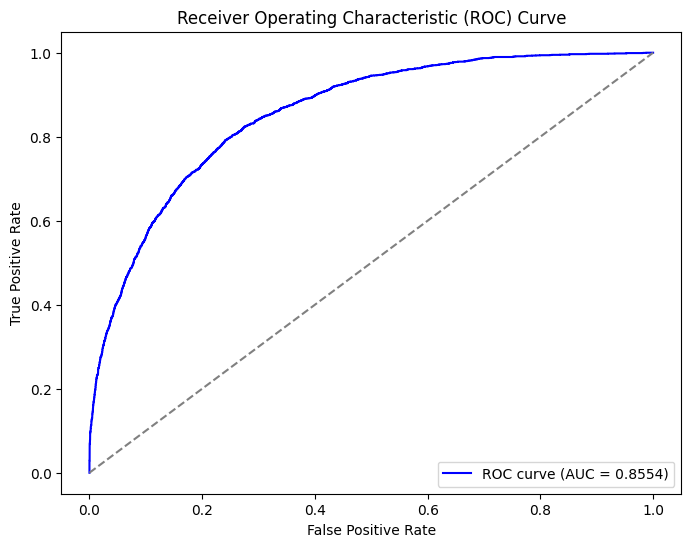

In [11]:
# Define the PyTorch model (MLP - Multi-layer Perceptron)
class MLPModel(nn.Module):
    def __init__(self, input_size):
        super(MLPModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        x = self.sigmoid(x)  # Sigmoid activation to output between 0 and 1
        return x

# Instantiate the model, loss function, and optimizer
model = MLPModel(input_size=X_train.shape[1])
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    y_pred = model(X_train_tensor)

    # Compute loss
    loss = criterion(y_pred, y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
y_test_pred = model(X_test_tensor).detach().numpy()

# Convert predictions to binary class labels (threshold at 0.5 for binary classification)
y_test_pred_class = (y_test_pred >= 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred_class)
precision = precision_score(y_test, y_test_pred_class)
recall = recall_score(y_test, y_test_pred_class)
f1 = f1_score(y_test, y_test_pred_class)
f1_squared = f1 ** 2
auc = roc_auc_score(y_test, y_test_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'F1 Squared: {f1_squared:.4f}')
print(f'AUC: {auc:.4f}')

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()